# Análise de Estrutura Secundária de Variantes — DRD4
Este notebook implementa um pipeline reprodutível para comparar previsões de estrutura secundária (SS) entre variantes da proteína DRD4.

Principais objetivos:
- Ler arquivos `.ss2` (estados H/E/C e probabilidades P(C), P(H), P(E)).
- Usar `NM_000797.4` como sequência de referência para indexação (pressupõe que os arquivos `.ss2` já estão alinhados entre si).
- Calcular métricas por posição (concordância estrita, consenso probabilístico, entropia, similaridade de cosseno, transições).
- Agregar métricas em janelas móveis e resumir regiões relevantes; gerar gráficos e tabelas exportáveis.

Premissas e comportamento em casos especiais:
- Entrada: arquivos `.ss2` alinhados entre si; se houver indels, as linhas devem já corresponder à mesma posição de referência.
- Gaps/posições ausentes: o código atual assume que cada arquivo tem a mesma quantidade de linhas; posições faltantes devem ser preenchidas previamente ou tratadas antes da análise.
- A ordem das variantes é a lista `variant_names` carregada do diretório `secondary_struct/`; algumas métricas (ex.: transições) contam mudanças nessa ordem — se desejar outra ordem, reindexe `variant_names` antes de rodar.

Saídas principais:
- `df_metricas`: DataFrame por posição com: pos, aa_ref, concordancia_estrita, media_P_C, media_P_H, media_P_E, entropia, media_similaridade_cosseno, transicoes.
- `df_janela`: DataFrame com agregados por janela móvel (start, end, media_concordancia_estrita, media_entropia, media_similaridade_cosseno, media_transicoes).
- Figuras: gráficos de linha, mapa de calor da entropia e barras de transições (salváveis com células de exportação).

Terminologia usada neste notebook:
- *Concordância estrita*: proporção (0/1 por posição) indicando se todas as variantes concordam no estado secundário naquela posição.
- *Consenso probabilístico*: médias das probabilidades (P_C, P_H, P_E) entre variantes na posição.
- *Entropia*: entropia de Shannon (base 2) do vetor de probabilidades médias — mede incerteza/discordância.
- *Similaridade de cosseno*: média das similaridades de cosseno pairwise entre vetores de probabilidade das variantes (valor máximo=1, mínimo≈0).

Use as células em ordem e ajuste parâmetros (p.ex. tamanho da janela) conforme necessário para suas análises.

In [93]:
# Organizar matrizes de SS e probabilidades por posição (dados já alinhados)
ref_name = 'NM_000797.4'
df_ref = all_data[ref_name]
variant_names = list(all_data.keys())

ss_matrix = []  # estados secundários por variante
prob_matrix = []  # probabilidades por variante (lista de dicts: P_C, P_H, P_E)

for i in range(len(df_ref)):
    ss_row = []
    prob_row = []
    for name in variant_names:
        row = all_data[name].iloc[i]
        ss_row.append(row['ss'])
        prob_row.append({'P_C': row['P_C'], 'P_H': row['P_H'], 'P_E': row['P_E']})
    ss_matrix.append(ss_row)
    prob_matrix.append(prob_row)

# Exemplo: estados e probabilidades na posição 10
print('SS na posição 10:', ss_matrix[9])
print('Probabilidades na posição 10:', prob_matrix[9])

SS na posição 10: ['C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'H', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']
Probabilidades na posição 10: [{'P_C': np.float64(0.75), 'P_H': np.float64(0.222), 'P_E': np.float64(0.018)}, {'P_C': np.float64(0.903), 'P_H': np.float64(0.12), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.711), 'P_H': np.float64(0.302), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.625), 'P_H': np.float64(0.394), 'P_E': np.float64(0.008)}, {'P_C': np.float64(0.791), 'P_H': np.float64(0.221), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.85), 'P_H': np.float64(0.159), 'P_E': np.float64(0.014)}, {'P_C': np.float64(0.905), 'P_H': np.float64(0.117), 'P_E': np.float64(0.011)}, {'P_C': np.float64(0.75), 'P_H': np.float64(0.222), 'P_E': np.float64(0.018)}, {'P_C': np.float64(0.831), 'P_H': np.float64(0.167), 'P_E': np.float64(0.012)}, {'P_C': np.float64(0.897), 'P_H': np.float64(0.123), '

## Organização dos dados alinhados
Esta célula organiza os dados extraídos dos arquivos `.ss2` já alinhados:
- Monta uma matriz de estados secundários (H/E/C) por posição para todas as variantes.
- Monta uma matriz de probabilidades (P_C, P_H, P_E) por posição para todas as variantes.
- Usa a sequência de referência `NM_000797.4` para garantir o alinhamento correto.
Essas matrizes serão usadas para calcular as métricas de concordância, consenso e divergência por posição.

## Cálculo das métricas por posição
A célula de cálculo gera um DataFrame (`df_metricas`) com medidas por posição que resumem o comportamento estrutural entre variantes. Explicação e detalhes:

- **Concordância estrita**: valor binário (1.0/0.0) — 1 se todas as variantes têm o mesmo estado secundário (H/E/C) na posição, 0 caso contrário. Para relatórios pode-se transformar em proporção se usar subconjuntos de variantes.
- **Consenso probabilístico (media_P_C, media_P_H, media_P_E)**: médias das probabilidades de cada estado entre as variantes — o vetor dessas três médias representa o perfil de consenso por posição.
- **Entropia**: entropia de Shannon (base 2) calculada sobre o vetor de probabilidades médias; maior entropia significa maior incerteza/discordância entre variantes quanto ao estado predominante.
- **Similaridade de cosseno média**: calcula a similaridade pairwise entre os vetores de probabilidade de cada variante e retorna a média dessas similaridades — valores próximos de 1 indicam perfis probabilísticos muito semelhantes entre variantes.
- **Transições**: conta quantas mudanças de estado secundário ocorrem ao percorrer a lista de variantes (ordem definida em `variant_names`) — útil para identificar posições onde a sequência de variantes tem alternâncias H↔E/C frequentes.

Observações importantes e limitações:
- Se houver valores NaN nas probabilidades, eles propagam para algumas métricas; é recomendável limpar ou imputar antes da análise se esse for o caso.
- A entropia é calculada sobre as probabilidades médias; portanto, dois perfis com médias idênticas terão a mesma entropia mesmo que a distribuição interna entre variantes seja diferente.
- A métrica de transições é dependente da ordem das variantes; para comparações independentes da ordem, calcule estatísticas alternativas (p.ex. número único de estados presentes).

In [94]:
from scipy.stats import entropy
from numpy.linalg import norm

def similaridade_cosseno(a, b):
    a, b = np.array(a), np.array(b)
    if norm(a) == 0 or norm(b) == 0:
        return np.nan
    return np.dot(a, b) / (norm(a) * norm(b))

metricas = []
for i, (ss_row, prob_row) in enumerate(zip(ss_matrix, prob_matrix)):
    # Concordância estrita (todas variantes concordam no estado secundário)
    concordancia_estrita = 1.0 if len(set(ss_row)) == 1 else 0.0
    # Consenso probabilístico: médias das probabilidades por estado
    media_probs = {k: np.mean([p[k] for p in prob_row]) for k in ['P_C', 'P_H', 'P_E']}
    # Entropia do consenso (incerteza/dispersão)
    entropia = entropy(list(media_probs.values()), base=2)
    # Média da similaridade de cosseno entre perfis de probabilidade das variantes
    cos_sims = []
    for idx1 in range(len(prob_row)):
        for idx2 in range(idx1+1, len(prob_row)):
            v1 = [prob_row[idx1]['P_C'], prob_row[idx1]['P_H'], prob_row[idx1]['P_E']]
            v2 = [prob_row[idx2]['P_C'], prob_row[idx2]['P_H'], prob_row[idx2]['P_E']]
            cos_sims.append(similaridade_cosseno(v1, v2))
    media_similaridade_cosseno = np.nanmean(cos_sims) if cos_sims else np.nan
    # Transições de estado entre variantes na posição (contagem de mudanças entre variantes)
    transicoes = sum([ss_row[j] != ss_row[j-1] for j in range(1, len(ss_row))])
    metricas.append({
        'pos': i+1,
        'aa_ref': df_ref.iloc[i]['aa'] if 'aa' in df_ref.columns else None,
        'concordancia_estrita': concordancia_estrita,
        'media_P_C': media_probs['P_C'],
        'media_P_H': media_probs['P_H'],
        'media_P_E': media_probs['P_E'],
        'entropia': entropia,
        'media_similaridade_cosseno': media_similaridade_cosseno,
        'transicoes': transicoes
    })

df_metricas = pd.DataFrame(metricas)
df_metricas.head()

,pos,aa_ref,concordancia_estrita,media_P_C,media_P_H,media_P_E,entropia,media_similaridade_cosseno,transicoes
0,1,M,1.0,0.999000,0.000750,0.000000,0.008869,1.000000,0
1,2,G,1.0,0.956778,0.025167,0.006833,0.230322,0.999954,0
2,3,N,1.0,0.904861,0.076583,0.016667,0.511082,0.998845,0
3,4,R,1.0,0.750500,0.176056,0.051944,0.963618,0.981453,0
4,5,S,0.0,0.627278,0.281083,0.055833,1.159922,0.949515,4


## Guia de interpretação das colunas e saídas
A seguir há uma explicação prática e rápida para interpretar cada coluna de `df_metricas`, `df_janela` e `df_segments_jaccard`, além das figuras geradas.

**Colunas de `df_metricas` (por posição)**
- `pos`: posição (1-based) na sequência de referência.
- `aa_ref`: aminoácido da referência nessa posição (quando disponível).
- `concordancia_estrita`: 1.0 se todas as variantes têm o mesmo estado secundário (H/E/C) naquela posição; 0.0 caso contrário. Use como filtro rápido de conservação estrutural.
- `media_P_C`, `media_P_H`, `media_P_E`: médias das probabilidades preditas para Coil/Helix/Sheet entre todas as variantes. O vetor dessas três colunas é o perfil de consenso; valores próximos a 1 em uma coluna indicam consenso forte naquele estado.
- `entropia`: entropia de Shannon (base 2) calculada sobre o vetor de probabilidades médias; mede incerteza. Intervalo: 0 (consenso absoluto) a log2(3) ≈ 1.585 (máxima incerteza entre 3 estados). Valores altos → posições divergentes ou incertas.
- `media_similaridade_cosseno`: média das similaridades de cosseno pairwise entre os vetores de probabilidade das variantes naquela posição; varia tipicamente entre 0 e 1. Valores perto de 1 indicam perfis muito semelhantes entre variantes.
- `transicoes`: número de mudanças de estado ao percorrer a lista ordenada de variantes (dependente da ordem em `variant_names`). Alto valor indica alternância frequente H↔E/C entre variantes.
- `kl_mean_ref_to_var`: média dos valores KL(ref || variante) em bits por posição — quantifica a mudança informacional entre o perfil da referência e os perfis das variantes (sensível a mudanças sutis nas probabilidades).
- `kl_max_ref_to_var`: maior KL observada entre ref e variantes naquela posição — sinaliza variantes com alterações informacionais pronunciadas.
- `kl_mean_consensus_to_var`: média de KL(consenso || variante) — compara cada variante ao perfil de consenso (útil quando a referência não é representativa).
- `*_ci_low` / `*_ci_high`: intervalos de confiança por bootstrap (entropia e kl_mean) — fornecem incerteza empírica; janelas largas indicam estimativas instáveis (p.ex. poucas variantes ou grande variabilidade).

**`df_janela` (agregados em janelas móveis)**
- `start`, `end`: posições inicial e final da janela na referência.
- `media_concordancia_estrita`, `media_entropia`, `media_similaridade_cosseno`, `media_transicoes`: médias das métricas dentro da janela — usadas para detectar regiões (pequenas/médias) com comportamento anômalo ou estável.
- Interpretação prática: janelas com `media_concordancia_estrita` ≥ 0.9 e `media_entropia` baixa costumam ser estruturalmente conservadas; janelas com `media_entropia` alta ou `media_transicoes` elevada merecem atenção.

**`df_segments_jaccard` e `df_seg_summary` (segmentos H/E da referência)**
- Cada `segment_id` representa um segmento contínuo de H (hélice) ou E (folha) na sequência de referência identificado automaticamente.
- `jaccard`: índice de Jaccard entre o conjunto de posições do segmento de referência e o conjunto de posições com o mesmo estado na variante (interseção/união).
- `df_seg_summary` contém `jaccard_mean` e `jaccard_std` por segmento — segmentos com baixa média significam perda/alteração do segmento na maioria das variantes.
- Uso: priorizar segmentos com Jaccard média baixa para inspeção (possível ganho/perda estrutural).

**Figuras e arquivos gerados**
- `fig_lines`: gráfico de linhas (métricas agregadas por janela) — fácil para visualizar tendências regionais.
- `fig_heatmap`: heatmap de entropia por posição (colormap robusto) — use para localizar hotspots de incerteza.
- `fig_trans`: barras de transições médias por janela — identifica zonas com alternâncias estruturais.
- `fig_logo`: logo probabilístico H/E/C (ou fallback) — visualiza o consenso por posição.
- Os CSVs `results/df_metricas.csv` e `results/df_janela.csv` contêm as tabelas para relatório e downstream analyses.

**Heurísticas práticas e prioridades**
- Priorize posições/segmentos com `entropia` alta **e** `concordancia_estrita` baixa — possibilidade real de mudança estrutural relevante.
- Use `kl_max_ref_to_var` para detectar variantes específicas que desviam fortemente da referência; investigue o contexto funcional dessas variantes.
- Combine Jaccard baixo em segmentos com picos de entropia para apontar ganhos/perdas locais de estrutura secundária.

**Caveats e recomendações**
- Este notebook assume que arquivos `.ss2` estão alinhados e têm o mesmo número de linhas; diferenças devem ser resolvidas antes da análise.
- Gaps não tratados podem distorcer jaccard/contagens — pre-processar se necessário.
- Estatísticas como bootstrap podem ser custosas; ajuste `B` para balancear precisão/tempo (ex.: B=200 rápido, B=1000 mais preciso).

Se quiser, eu adiciono uma célula de exemplo que aplica filtros de priorização (ex.: retornar top 20 posições por `kl_mean_ref_to_var` + `entropia`) e exporta esse conjunto para `results/` — eu implemento?

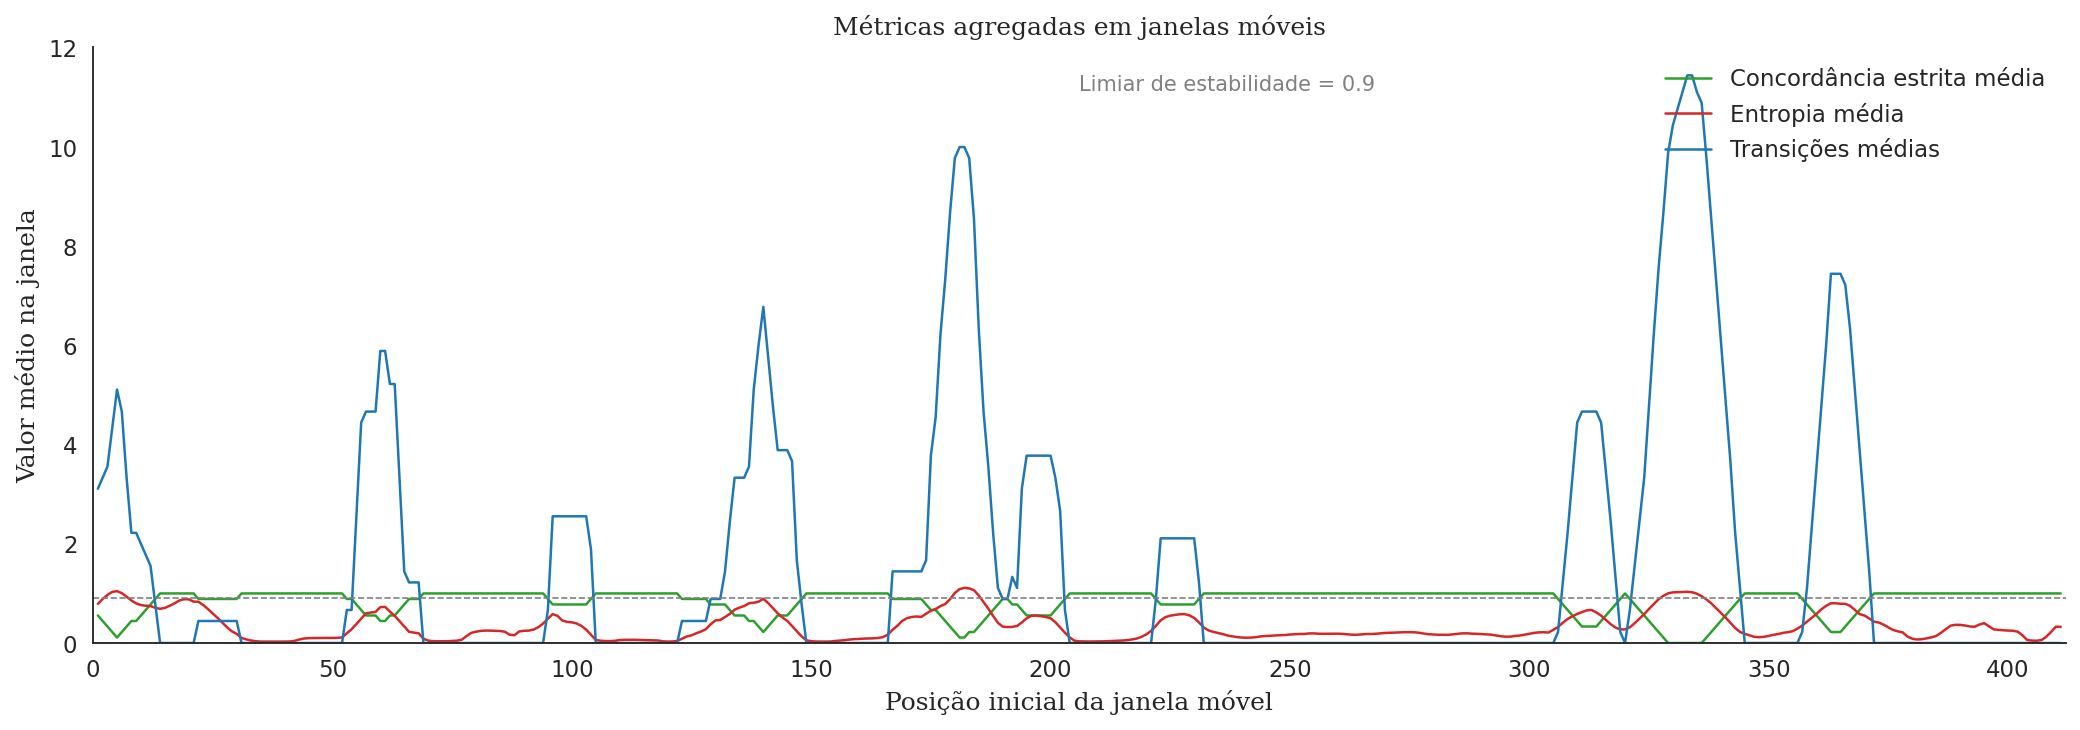

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo para artigo científico
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif'],
    'font.size': 11,
    'axes.linewidth': 0.9,
    'lines.linewidth': 1.2,
    'figure.dpi': 150,
    'axes.grid': False
})

fig, ax = plt.subplots(figsize=(14,5))
sns.set_style('white')

# Plot das métricas
ax.plot(df_janela['start'], df_janela['media_concordancia_estrita'], label='Concordância estrita média', color='#2ca02c')
ax.plot(df_janela['start'], df_janela['media_entropia'], label='Entropia média', color='#d62728')
ax.plot(df_janela['start'], df_janela['media_transicoes'], label='Transições médias', color='#1f77b4')

# Rótulos e título
ax.set_xlabel('Posição inicial da janela móvel')
ax.set_ylabel('Valor médio na janela')
ax.set_title('Métricas agregadas em janelas móveis')

# Definir limites para garantir 0 nas margens (zero colado aos eixos)
ax.set_xlim(0, df_janela['start'].max() + 1)
ymax = max(df_janela[['media_concordancia_estrita','media_entropia','media_transicoes']].max()) * 1.05
ax.set_ylim(0, ymax)

# Limpar espinhas superiores/direitas e posicionar espinhas esquerda/inferior coladas ao 0
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

# Ticks externos e legenda simples
ax.tick_params(axis='both', which='both', direction='out', length=4)
ax.legend(frameon=False, loc='upper right')

# Limiar de referência
ax.axhline(0.9, color='gray', linestyle='--', linewidth=0.8)
ax.text(0.5, 0.92, 'Limiar de estabilidade = 0.9', transform=ax.transAxes, ha='left', va='bottom', color='gray', fontsize=10)

plt.tight_layout()
plt.show()

## Detalhes da agregação em janelas móveis
Esta célula realiza a agregação das métricas calculadas por posição em janelas móveis ao longo da proteína. Para cada janela (exemplo: 9 resíduos), são calculadas as médias das principais métricas.

**Tabela gerada (`df_window`):**
- `start`: posição inicial da janela na sequência de referência.
- `end`: posição final da janela.
- `mean_hard_concord`: média da concordância estrita na janela (proporção de posições em que todas as variantes concordam no estado secundário).
- `mean_entropy`: média da entropia do consenso na janela (mede a incerteza/dispersão das probabilidades dos estados secundários; valores altos indicam maior divergência entre variantes).
- `mean_cos_sim`: média da similaridade de cosseno entre os vetores de probabilidade das variantes na janela (valores próximos de 1 indicam variantes semelhantes, próximos de 0 indicam divergência).
- `mean_transitions`: média do número de transições de estado secundário entre variantes por posição na janela (mais transições indicam maior discordância estrutural).

Essas médias suavizam o ruído posição a posição e ajudam a identificar regiões estáveis, divergentes ou potencialmente relevantes para função ou fenótipo.

## Detalhes da visualização das métricas agregadas
Esta célula gera gráficos de linha para as principais métricas agregadas em janelas móveis ao longo da proteína.

**Gráficos gerados:**
- **Concordância estrita média**: mostra, para cada janela, a proporção de posições em que todas as variantes concordam no estado secundário (H/E/C). Valores próximos de 1 indicam alta estabilidade estrutural; valores baixos indicam regiões divergentes.
- **Entropia média**: indica o grau de incerteza ou dispersão das probabilidades dos estados secundários entre variantes. Valores altos sugerem maior discordância ou variabilidade estrutural.
- **Transições médias**: mostra o número médio de mudanças de estado secundário entre variantes por posição na janela. Regiões com muitos H↔E/C indicam potencial relevância funcional ou instabilidade.

Esses gráficos permitem identificar rapidamente regiões estáveis, divergentes e potenciais pontos críticos funcionais ou estruturais na proteína.

**Gráfico 1: Métricas agregadas em janelas móveis**
Este gráfico mostra, ao longo da proteína, as médias das principais métricas calculadas em janelas móveis:
- **Concordância estrita média (verde):** Proporção de posições em que todas as variantes concordam no estado secundário. Valores altos indicam regiões estáveis.
- **Entropia média (vermelho):** Mede a incerteza/dispersão das probabilidades dos estados secundários. Valores altos indicam maior divergência entre variantes.
- **Transições médias (azul):** Número médio de mudanças de estado secundário entre variantes por posição. Regiões com muitos H↔E/C indicam potencial relevância funcional ou instabilidade.
A linha cinza tracejada indica o limiar de estabilidade (0,9).

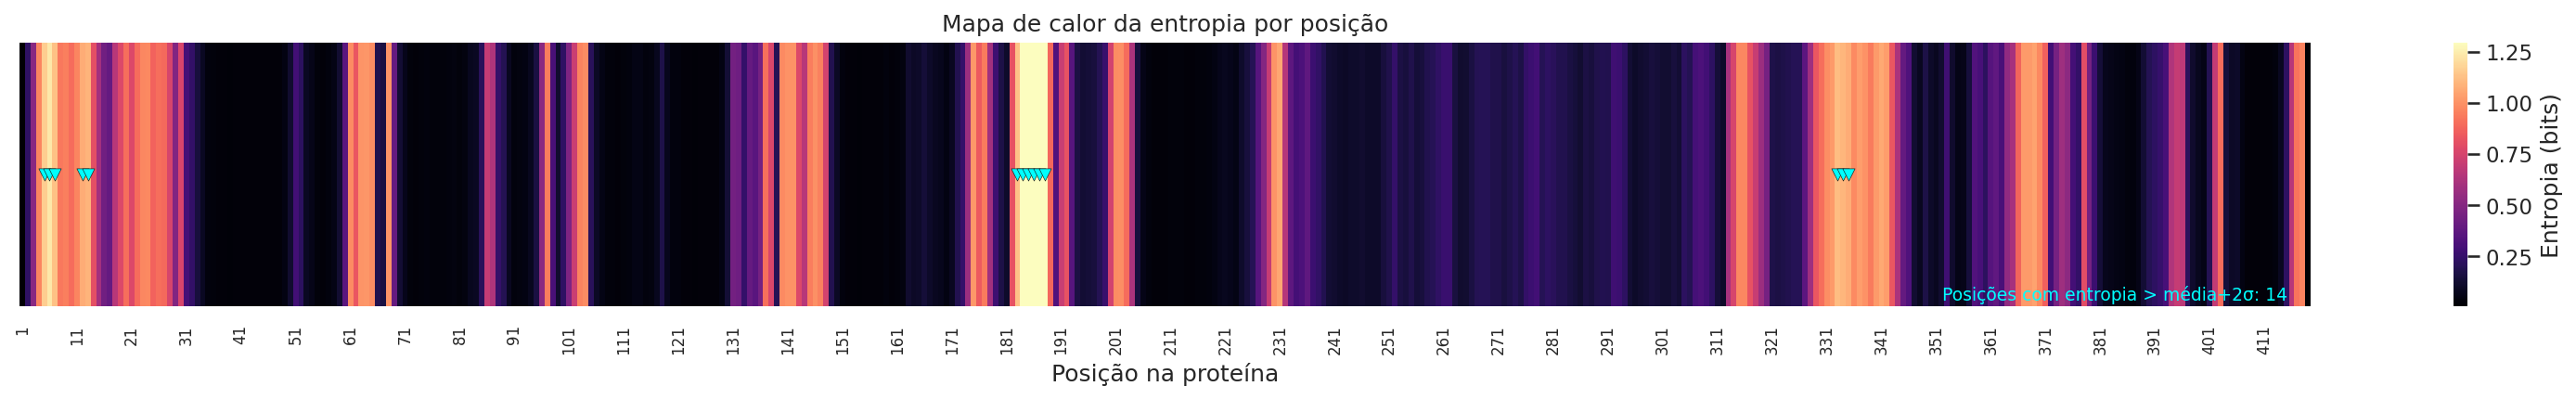

In [96]:
# Heatmap horizontal da entropia por posição com números das posições na vertical
import numpy as np
fig, ax = plt.subplots(figsize=(max(8, len(df_metricas)/20), 3))  # figura larga para leitura horizontal
sns.set_style('white')

# Converter para array 1 x N (heatmap horizontal)
ent = df_metricas['entropia'].values.reshape(1, -1)

# Limites robustos para a cor (evita que outliers comprimam a escala)
vmin = np.nanmin(ent)
vmax = np.nanpercentile(ent, 99)

# Plot do heatmap (1 x N)
im = sns.heatmap(ent, cmap='magma', cbar_kws={'label': 'Entropia (bits)'}, ax=ax,
                 vmin=vmin, vmax=vmax, yticklabels=False)

# Ajustes dos ticks no eixo x: mostrar rótulos a cada step para legibilidade e rotacionar verticalmente
n = ent.shape[1]
step = 10 if n > 200 else (5 if n > 100 else (2 if n > 50 else 1))
xticks = np.arange(0, n, step)
ax.set_xticks(xticks + 0.5)
ax.set_xticklabels((xticks + 1).tolist(), rotation=90, fontsize=8)
ax.set_xlabel('Posição na proteína')
ax.set_title('Mapa de calor da entropia por posição')

# Remover bordas desnecessárias
for spine in ['top', 'right', 'left', 'bottom']:
    ax.spines[spine].set_visible(False)

# Identificar posições de alta entropia (ex.: > média + 2*sd) e marcar
mean_e = np.nanmean(ent)
std_e = np.nanstd(ent)
threshold = mean_e + 2 * std_e
high_idx = np.where(ent.flatten() > threshold)[0]
if high_idx.size > 0:
    # marcadores abaixo do heatmap (y=0.5)
    ax.scatter(high_idx + 0.5, np.repeat(0.5, high_idx.size), marker='v',
               color='cyan', s=40, edgecolor='k', linewidth=0.3, zorder=10)
    ax.text(0.99, 0.01, f'Posições com entropia > média+2σ: {len(high_idx)}',
            transform=ax.transAxes, ha='right', va='bottom', fontsize=9, color='cyan')

plt.tight_layout()
plt.show()

**Gráfico 2: Mapa de calor da entropia por posição (vertical)**
Este gráfico apresenta a entropia (incerteza/divergência) das probabilidades dos estados secundários em cada posição da proteína, com as posições dispostas verticalmente para facilitar a leitura em sequências longas.
- O eixo y representa a posição na sequência (resíduos); o eixo x é apenas a coluna do heatmap.
- Tons mais escuros representam maior entropia (maior discordância entre variantes); tons claros indicam maior consenso e estabilidade estrutural.
- O mapa usa limites robustos de cor (percentil 99) para evitar compressão por outliers.
- Posições de 'alta entropia' (definidas como entropia > média + 2σ) são marcadas com triângulos cianos à direita do heatmap; o contador informa quantas posições excedem esse limiar.

Interpretação prática: posições verticais com cor escura e marcador ciano são hotspots de variáveis estrutu- ramente relevantes e merecem investigação adicional (mutações, ligação, dominios).

In [97]:
# Célula de exportação: salva resultados e figuras para pastas 'results/' e 'figures/'
import os
os.makedirs('results', exist_ok=True)
os.makedirs('figures', exist_ok=True)

# Salvar dataframes principais
df_metricas.to_csv(os.path.join('results', 'df_metricas.csv'), index=False)
df_janela.to_csv(os.path.join('results', 'df_janela.csv'), index=False)
print('Dataframes salvos em results/')

# Salvar as figuras atualmente no estado (tenta salvar a figura ativa)
try:
    fig_lines.savefig(os.path.join('figures', 'metrica_janelas.png'), bbox_inches='tight')
    print('Figura de linhas salva em figures/metrica_janelas.png')
except NameError:
    print('Figura de linhas não encontrada (variável fig_lines). Rode a célula de plotagem antes de exportar).')

try:
    fig_heatmap.savefig(os.path.join('figures', 'heatmap_entropia.png'), bbox_inches='tight')
    print('Heatmap salvo em figures/heatmap_entropia.png')
except NameError:
    print('Heatmap não encontrado (variável fig_heatmap). Rode a célula de heatmap antes de exportar).')

try:
    fig_trans.savefig(os.path.join('figures', 'transicoes_barras.png'), bbox_inches='tight')
    print('Gráfico de transições salvo em figures/transicoes_barras.png')
except NameError:
    print('Gráfico de transições não encontrado (variável fig_trans). Rode a célula de barras antes de exportar).')

Dataframes salvos em results/
Figura de linhas salva em figures/metrica_janelas.png
Figura de linhas salva em figures/metrica_janelas.png
Heatmap salvo em figures/heatmap_entropia.png
Heatmap salvo em figures/heatmap_entropia.png
Gráfico de transições salvo em figures/transicoes_barras.png
Gráfico de transições salvo em figures/transicoes_barras.png


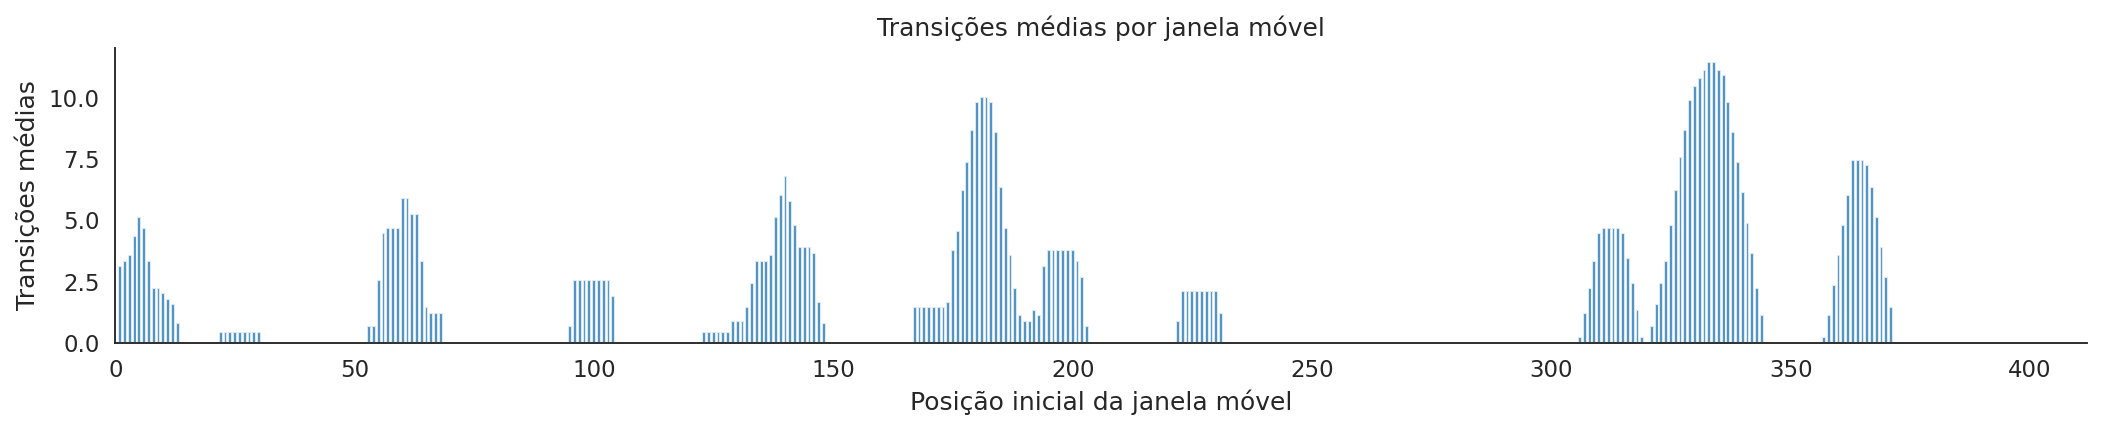

In [98]:
fig, ax = plt.subplots(figsize=(14,3))
sns.set_style('white')

ax.bar(df_janela['start'], df_janela['media_transicoes'], color='#1f77b4', alpha=0.8)

ax.set_xlabel('Posição inicial da janela móvel')
ax.set_ylabel('Transições médias')
ax.set_title('Transições médias por janela móvel')

ax.set_xlim(0, df_janela['start'].max() + 1)
ax.set_ylim(0, df_janela['media_transicoes'].max() * 1.05)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))

ax.tick_params(axis='both', which='both', direction='out', length=4)

plt.tight_layout()
plt.show()

In [99]:
# 1) KL divergence por posição (referência -> cada variante): média e máximo
from scipy.stats import entropy as scipy_entropy
eps = 1e-8
kl_mean_list = []
kl_max_list = []
kl_consensus_mean_list = []
for i, prob_row in enumerate(prob_matrix):
    # vetor da referência (ordem de colunas P_C,P_H,P_E)
    p_ref = np.array([df_ref.iloc[i]['P_C'], df_ref.iloc[i]['P_H'], df_ref.iloc[i]['P_E']])
    p_ref = np.clip(p_ref, eps, 1.0); p_ref = p_ref / p_ref.sum()
    # consenso (médias armazenadas em df_metricas) - usar para comparação alternativa
    consensus = np.array([df_metricas.loc[i,'media_P_C'], df_metricas.loc[i,'media_P_H'], df_metricas.loc[i,'media_P_E']])
    consensus = np.clip(consensus, eps, 1.0); consensus = consensus / consensus.sum()
    kls = []
    kls_cons = []
    for v in prob_row:
        p_var = np.array([v['P_C'], v['P_H'], v['P_E']])
        p_var = np.clip(p_var, eps, 1.0); p_var = p_var / p_var.sum()
        # KL(ref || var) em bits (base=2)
        k = scipy_entropy(p_ref, p_var, base=2)
        k_cons = scipy_entropy(consensus, p_var, base=2)
        kls.append(k); kls_cons.append(k_cons)
    kl_mean_list.append(np.mean(kls))
    kl_max_list.append(np.max(kls))
    kl_consensus_mean_list.append(np.mean(kls_cons))

df_metricas['kl_mean_ref_to_var'] = kl_mean_list
df_metricas['kl_max_ref_to_var'] = kl_max_list
df_metricas['kl_mean_consensus_to_var'] = kl_consensus_mean_list

print('KL calculado e adicionado a df_metricas')
df_metricas

KL calculado e adicionado a df_metricas


,pos,aa_ref,concordancia_estrita,media_P_C,media_P_H,media_P_E,entropia,media_similaridade_cosseno,transicoes,kl_mean_ref_to_var,kl_max_ref_to_var,kl_mean_consensus_to_var
0,1,M,1.0,0.999000,0.000750,0.000000,0.008869,1.000000,0,0.003792,0.015166,0.002804
1,2,G,1.0,0.956778,0.025167,0.006833,0.230322,0.999954,0,0.002647,0.011445,0.001427
2,3,N,1.0,0.904861,0.076583,0.016667,0.511082,0.998845,0,0.011700,0.058859,0.010587
3,4,R,1.0,0.750500,0.176056,0.051944,0.963618,0.981453,0,0.056719,0.283659,0.059590
4,5,S,0.0,0.627278,0.281083,0.055833,1.159922,0.949515,4,0.094181,0.492988,0.097470
...,...,...,...,...,...,...,...,...,...,...,...,...
414,415,L,1.0,0.034389,0.970000,0.001000,0.226362,0.999929,0,0.002200,0.009924,0.001347
415,416,R,1.0,0.161806,0.846528,0.001417,0.649856,0.993807,0,0.029922,0.086722,0.017260
416,417,A,1.0,0.306889,0.694361,0.003417,0.918859,0.975057,0,0.072233,0.172579,0.026698
417,418,C,1.0,0.350389,0.655389,0.003028,0.959286,0.982481,0,0.064873,0.145250,0.015518


In [100]:
# 2) Jaccard de segmentos H/E por variante (comparar segmentos da referência com cada variante)
def get_segments_from_ss(ss_series, state):
    segments = []
    start = None
    for idx, s in enumerate(ss_series, start=1):
        if s == state and start is None:
            start = idx
        if s != state and start is not None:
            segments.append((start, idx-1))
            start = None
    if start is not None:
        segments.append((start, len(ss_series)))
    return segments

# construir lista de SS por variante (usando ss_matrix construída anteriormente)
ss_by_variant = {name: [row[j] for row in ss_matrix] for j, name in enumerate(variant_names)}
# referência
ref_ss = ss_by_variant[ref_name]
segments = []
for state in ['H','E']:
    segs = get_segments_from_ss(ref_ss, state)
    for seg_id, (sstart, send) in enumerate(segs, start=1):
        seg_positions = set(range(sstart, send+1))
        for var in variant_names:
            var_positions = set([i+1 for i, x in enumerate(ss_by_variant[var]) if x == state])
            inter = len(seg_positions & var_positions)
            uni = len(seg_positions | var_positions)
            jacc = inter / uni if uni > 0 else np.nan
            segments.append({
                'segment_id': f'ref_{state}_{seg_id}',
                'state': state,
                'start': sstart,
                'end': send,
                'ref_len': send - sstart + 1,
                'variant': var,
                'jaccard': jacc
            })

df_segments_jaccard = pd.DataFrame(segments)
# resumo por segmento (média e desvio)
df_seg_summary = df_segments_jaccard.groupby(['segment_id','state','start','end','ref_len']).jaccard.agg(['mean','std','count']).reset_index().rename(columns={'mean':'jaccard_mean','std':'jaccard_std'})
print('Jaccard por segmento gerado: df_segments_jaccard e resumo em df_seg_summary')
df_segments_jaccard.head()

Jaccard por segmento gerado: df_segments_jaccard e resumo em df_seg_summary


,segment_id,state,start,end,ref_len,variant,jaccard
0,ref_H_1,H,12,13,2,HM191426.1,0.0
1,ref_H_1,H,12,13,2,HM191427.1,0.0
2,ref_H_1,H,12,13,2,HM191428.1,0.0
3,ref_H_1,H,12,13,2,HM191429.1,0.0
4,ref_H_1,H,12,13,2,HM191430.1,0.0


In [101]:
# 3) Bootstrap para intervalos de confiança (entropia e KL medios) por posição e janelas
import random
def bootstrap_ci(values_func, prob_rows, B=500, alpha=0.05):
    stats = []
    n = len(prob_rows)
    for b in range(B):
        idxs = np.random.randint(0, n, n)
        sample = [prob_rows[i] for i in idxs]
        stats.append(values_func(sample))
    lo = np.percentile(stats, 100 * (alpha/2))
    hi = np.percentile(stats, 100 * (1 - alpha/2))
    return lo, hi

# função para calcular entropia de um conjunto de prob rows (média de prob -> entropia)
def entropy_of_sample(sample_rows):
    mean_p = np.mean([[r['P_C'], r['P_H'], r['P_E']] for r in sample_rows], axis=0)
    mean_p = np.clip(mean_p, 1e-8, 1.0); mean_p = mean_p / mean_p.sum()
    return scipy_entropy(mean_p, base=2)

# realizar bootstrap por posição
ent_lo = []; ent_hi = []; kl_lo = []; kl_hi = []
for i, prob_row in enumerate(prob_matrix):
    lo, hi = bootstrap_ci(entropy_of_sample, prob_row, B=300)
    ent_lo.append(lo); ent_hi.append(hi)
    # para KL média ref->var (já calculada por posição) faremos bootstrap da média dos KLs
    def mean_kl_sample(sample_rows):
        # sample_rows here are prob dicts sampled; compute kl(ref||var) mean
        p_ref = np.array([df_ref.iloc[i]['P_C'], df_ref.iloc[i]['P_H'], df_ref.iloc[i]['P_E']])
        p_ref = np.clip(p_ref, 1e-8, 1.0); p_ref = p_ref / p_ref.sum()
        ks = []
        for r in sample_rows:
            p_var = np.array([r['P_C'], r['P_H'], r['P_E']])
            p_var = np.clip(p_var, 1e-8, 1.0); p_var = p_var / p_var.sum()
            ks.append(scipy_entropy(p_ref, p_var, base=2))
        return np.mean(ks)
    klo, khi = bootstrap_ci(mean_kl_sample, prob_row, B=300)
    kl_lo.append(klo); kl_hi.append(khi)

df_metricas['entropia_ci_low'] = ent_lo
df_metricas['entropia_ci_high'] = ent_hi
df_metricas['kl_mean_ci_low'] = kl_lo
df_metricas['kl_mean_ci_high'] = kl_hi
print('Bootstrap CI calculados (entropia e kl mean) e adicionados a df_metricas')

KeyboardInterrupt: 

Logo criado (ou fallback desenhado) — figura em fig_logo


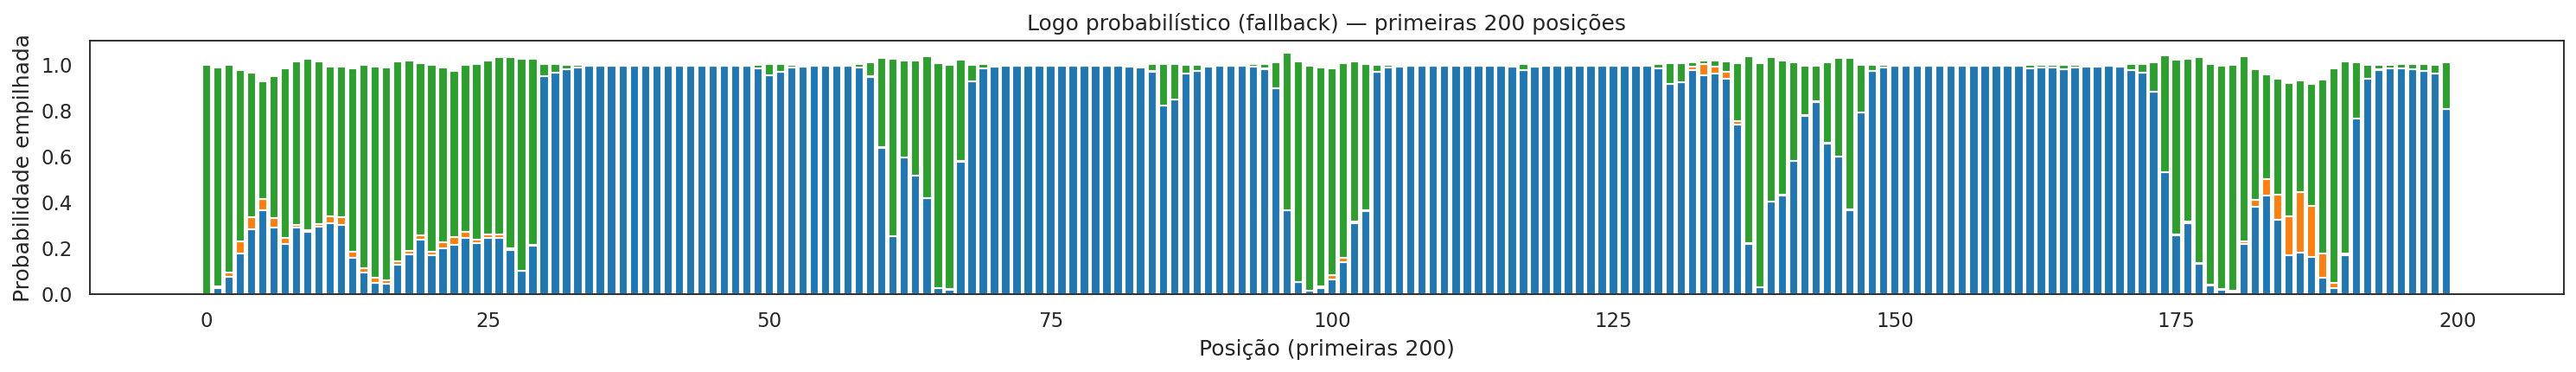

In [102]:
# 8) Logo probabilístico das probabilidades médias por posição (H,E,C)
try:
    import logomaker
    has_logo = True
except Exception:
    has_logo = False

prob_df = pd.DataFrame({
    'H': df_metricas['media_P_H'].values,
    'E': df_metricas['media_P_E'].values,
    'C': df_metricas['media_P_C'].values,
})

if has_logo:
    fig_logo, ax = plt.subplots(figsize=(min(20, len(prob_df)/5), 3))
    logo = logomaker.Logo(prob_df, ax=ax, color_scheme={'H':'#1f77b4','E':'#ff7f0e','C':'#2ca02c'})
    ax.set_xlabel('Posição')
    ax.set_title('Logo probabilístico (H/E/C) — probabilidades médias por posição')
    plt.tight_layout()
else:
    # fallback: stacked bar for first 200 positions
    maxpos = min(200, len(prob_df))
    fig_logo, ax = plt.subplots(figsize=(max(8, maxpos/10), 3))
    x = np.arange(maxpos)
    pH = prob_df['H'].values[:maxpos]
    pE = prob_df['E'].values[:maxpos]
    pC = prob_df['C'].values[:maxpos]
    ax.bar(x, pH, color='#1f77b4')
    ax.bar(x, pE, bottom=pH, color='#ff7f0e')
    ax.bar(x, pC, bottom=pH+pE, color='#2ca02c')
    ax.set_xlabel('Posição (primeiras %d)' % maxpos)
    ax.set_ylabel('Probabilidade empilhada')
    ax.set_title('Logo probabilístico (fallback) — primeiras %d posições' % maxpos)
    plt.tight_layout()

print('Logo criado (ou fallback desenhado) — figura em fig_logo')

Figuras principais recriadas em fig_lines, fig_heatmap, fig_trans


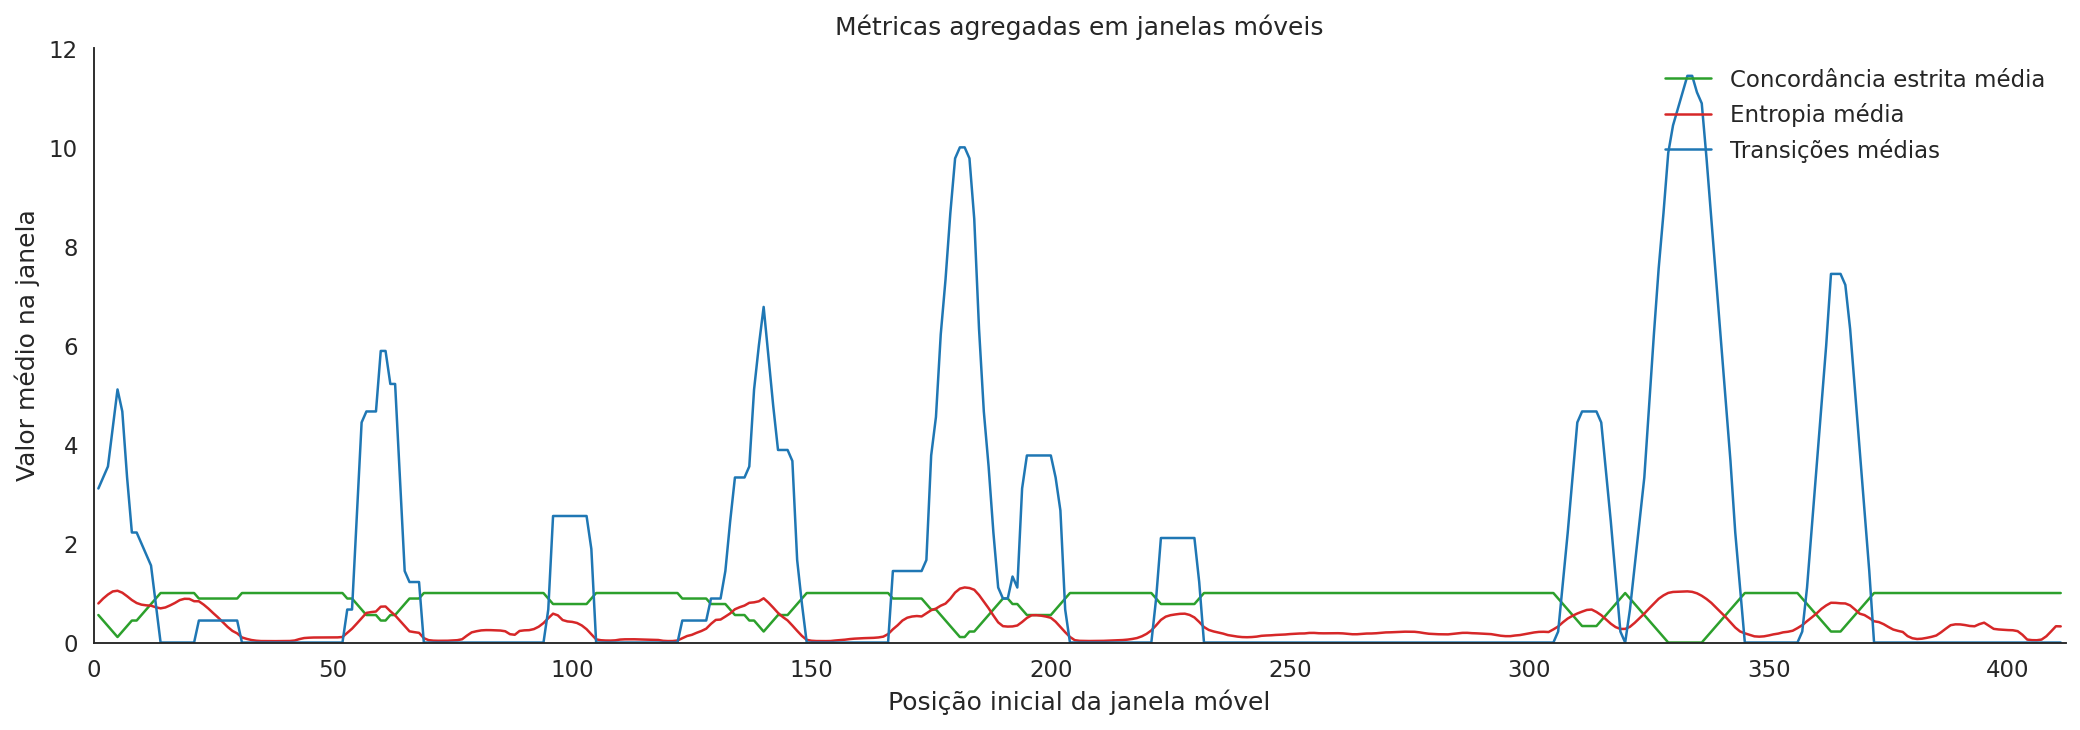

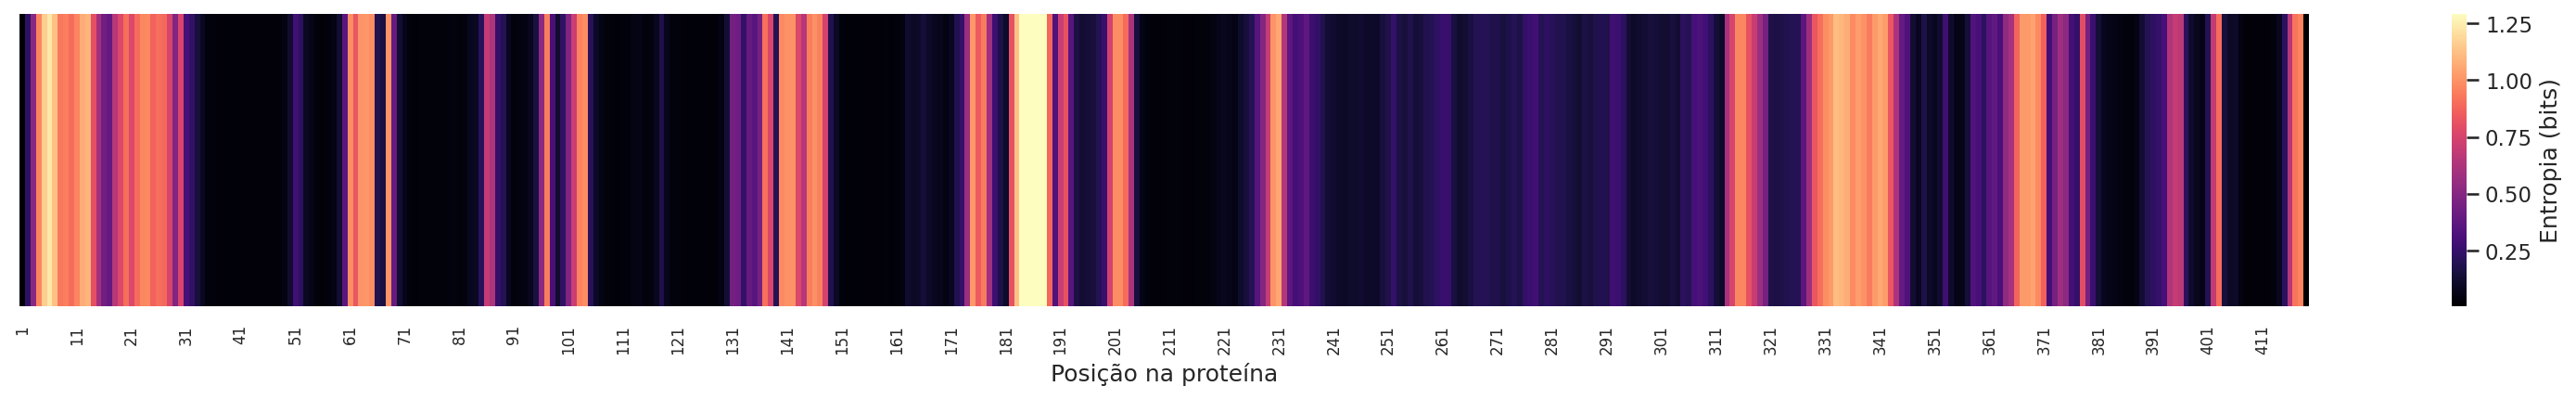

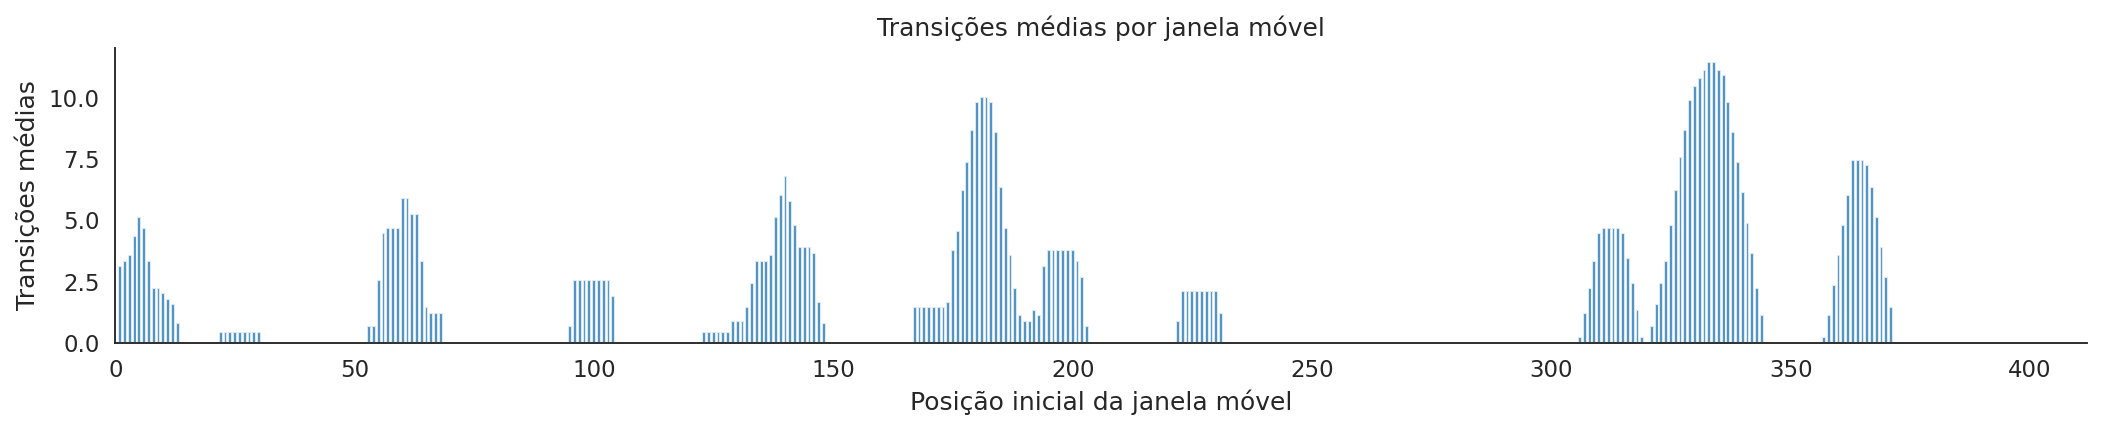

In [ ]:
#  Extra: Recriar as figuras principais com nomes conhecidos para exportação (fig_lines, fig_heatmap, fig_trans)
# Figura de linhas (métricas por janela)
fig_lines, ax = plt.subplots(figsize=(14,5))
ax.plot(df_janela['start'], df_janela['media_concordancia_estrita'], label='Concordância estrita média', color='#2ca02c')
ax.plot(df_janela['start'], df_janela['media_entropia'], label='Entropia média', color='#d62728')
ax.plot(df_janela['start'], df_janela['media_transicoes'], label='Transições médias', color='#1f77b4')
ax.set_xlabel('Posição inicial da janela móvel')
ax.set_ylabel('Valor médio na janela')
ax.set_title('Métricas agregadas em janelas móveis')
ax.set_xlim(0, df_janela['start'].max() + 1)
ymax = max(df_janela[['media_concordancia_estrita','media_entropia','media_transicoes']].max()) * 1.05
ax.set_ylim(0, ymax)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.tick_params(axis='both', which='both', direction='out', length=4)
ax.legend(frameon=False, loc='upper right')
plt.tight_layout()

# Figura heatmap de entropia (usando a matriz 1xN horizontal)
fig_heatmap, ax = plt.subplots(figsize=(max(8, len(df_metricas)/20), 3))
ent = df_metricas['entropia'].values.reshape(1, -1)
vmin = np.nanmin(ent); vmax = np.nanpercentile(ent, 99)
sns.heatmap(ent, cmap='magma', cbar_kws={'label':'Entropia (bits)'}, ax=ax, vmin=vmin, vmax=vmax, yticklabels=False)
n = ent.shape[1]
step = 10 if n > 200 else (5 if n > 100 else (2 if n > 50 else 1))
xticks = np.arange(0, n, step)
ax.set_xticks(xticks + 0.5)
ax.set_xticklabels((xticks + 1).tolist(), rotation=90, fontsize=8)
ax.set_xlabel('Posição na proteína')
plt.tight_layout()

# Figura de transições por janela
fig_trans, ax = plt.subplots(figsize=(14,3))
ax.bar(df_janela['start'], df_janela['media_transicoes'], color='#1f77b4', alpha=0.8)
ax.set_xlabel('Posição inicial da janela móvel')
ax.set_ylabel('Transições médias')
ax.set_title('Transições médias por janela móvel')
ax.set_xlim(0, df_janela['start'].max() + 1)
ax.set_ylim(0, df_janela['media_transicoes'].max() * 1.05)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.tick_params(axis='both', which='both', direction='out', length=4)
plt.tight_layout()

print('Figuras principais recriadas em fig_lines, fig_heatmap, fig_trans')

**Gráfico 3: Transições médias por janela móvel**
Este gráfico mostra, para cada janela móvel ao longo da proteína, o número médio de transições de estado secundário entre variantes.
- Barras mais altas indicam regiões com maior discordância estrutural entre variantes (mais mudanças de H↔E/C).
- Barras baixas indicam regiões mais estáveis e conservadas.
Este gráfico é útil para identificar hotspots de variabilidade estrutural e potenciais regiões de interesse funcional.